![My Image](https://raw.githubusercontent.com/ralf-42/Image/main/genai-banner-2.jpg)

<p><font size="5" color='grey'> <b>
LangGraph 101
</b></font> </br></p>

---

In [1]:
#@title 🔧 Umgebung einrichten{ display-mode: "form" }
!uv pip install --system -q git+https://github.com/ralf-42/GenAI.git#subdirectory=04_modul
from genai_lib.utilities import check_environment, get_ipinfo, setup_api_keys, mprint, install_packages
setup_api_keys(['OPENAI_API_KEY'], create_globals=False)
print()
check_environment()
print()
get_ipinfo()

✓ OPENAI_API_KEY erfolgreich gesetzt

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

Installierte LangChain-Bibliotheken:
langchain                                1.1.0
langchain-chroma                         1.0.0
langchain-classic                        1.0.0
langchain-community                      0.4.1
langchain-core                           1.1.0
langchain-ollama                         1.0.0
langchain-openai                         1.1.0
langchain-text-splitters                 1.0.0

Installierte LangGraph-Bibliotheken:
langgraph                                1.0.3
langgraph-checkpoint                     3.0.1
langgraph-prebuilt                       1.0.5
langgraph-sdk                            0.2.10

IP-Adresse: 34.60.90.169
Hostname: 169.90.60.34.bc.googleusercontent.com
Stadt: Council Bluffs
Region: Iowa
Land: US
Koordinaten: 41.2619,-95.8608
Provider: AS396982 Google LLC
Postleitzahl: 51502
Zeitzone: America/Chicago


# 1 | Einleitung: Warum LangGraph?
---


LangGraph erweitert LangChain um die Möglichkeit, **Entscheidungen zu treffen** und **mehrere Schritte zu koordinieren**. Statt einer linearen Kette von Aufgaben können Sie Workflows bauen, die:

- Abhängig vom Ergebnis unterschiedliche Wege gehen (z.B. "Brauche ich ein Tool?")
- Informationen über mehrere Schritte hinweg "merken" (State Management)
- Schleifen durchlaufen (z.B. "Versuche es nochmal, wenn das Ergebnis falsch ist")

**Praktisches Beispiel:**

Stellen Sie sich einen Chatbot vor, der:

1. Eine Frage bekommt
2. Entscheidet: "Brauche ich externe Daten?"
3. Falls ja → Ruft eine Datenbank auf
4. Falls nein → Antwortet direkt
5. Prüft die Antwort und korrigiert ggf.

Mit LangChain müssten Sie diese Logik manuell programmieren. Mit LangGraph definieren Sie einen Graphen, der automatisch den richtigen Weg geht.

**Kernfunktionen:**

- **Zustandsverwaltung (State):** Automatisches Speichern von Informationen zwischen Schritten
- **Verzweigungen:** "Wenn/Dann"-Logik für flexible Workflows
- **Checkpointing:** Workflows können pausiert und später fortgesetzt werden


# 2 | LangGraph vs. LangChain
---


LangGraph nutzt die Komponenten von LangChain, verschiebt aber den Fokus von sequenziellen Abläufen hin zu dynamischer Steuerung.

| **Kategorie**      | **LangChain**                          | **LangGraph**                                    |
| ------------------ | -------------------------------------- | ------------------------------------------------ |
| **Struktur**       | Schritt 1 → Schritt 2 → Schritt 3     | Verzweigungen möglich (wenn/dann Logik)          |
| **Beispiel**       | "Übersetze, dann fasse zusammen"       | "Wenn Frage → suche Daten, sonst → antworte"    |
| **State**          | Manuelles Speichern nötig              | Automatisches Speichern zwischen Schritten       |
| **Wann nutzen?**   | Einfache, vorhersehbare Abläufe       | Komplexe Workflows mit Entscheidungen           |
| **Kernobjekte**    | `Chain`, `Agent`                       | `StateGraph`, `START`, `END`                     |


# 3 | Workflow, Graph, State
---


Die Begriffe Workflow und Graph werden oft synonym verwendet, aber eine klare Abgrenzung hilft dem Verständnis:    
+ Workflow = **WAS** soll passieren (Geschäftslogik)
+ Graph = **WIE** es technisch umgesetzt wird (Datenstruktur)

| Aspekt | Workflow | Graph |
|--------|----------|-------|
| **Perspektive** | Fachlich / Konzeptionell | Technisch / Implementierung |
| **Beschreibt** | Den Ablauf / Prozess | Die Struktur / Architektur |
| **Beispiel** | "Bestellung prüfen → bezahlen → versenden" | Knoten A → Knoten B → Knoten C |
| **Formulierung** | "Der Workflow entscheidet, ob..." | "Der Graph hat eine bedingte Kante..." |
| **Zielgruppe** | Geschäftslogik, User Stories | Entwickler, Technische Umsetzung |
| **Artefakt** | Flussdiagramm, Prozessbeschreibung | StateGraph-Objekt, Code |

Die Logik wird in **Knoten** (`nodes`) gekapselt, und der Fluss wird durch **Kanten** (`edges`) definiert.

**Übersicht der Begriffe/Konzepte LangChain:**

| Begriff | Bedeutung |
|---------|-----------|
| **State** | Datencontainer, der durch alle Knoten fließt |
| **Node** | Ein Schritt/Aufgabe im Workflow (≈ Python-Funktion) |
| **Edge** | Verbindung zwischen Knoten (definiert den Ablauf) |
| **Workflow** | Der fachliche Ablauf: "Was soll in welcher Reihenfolge passieren?" |
| **Graph** | Die technische Umsetzung des Workflows aus Nodes + Edges |
| **START** | Spezieller Knoten: Einstiegspunkt |
| **END** | Spezieller Knoten: Endpunkt |
| **Conditional Edge** | Verzweigung: "Gehe zu Knoten A ODER B" |
| **Checkpointer** | Speichert den State, damit nichts verloren geht |
| **Router** | Knoten, der entscheidet, welcher Pfad genommen wird |
| **Builder** | Objekt zum Aufbauen des Graphen (StateGraph) |

<img src="https://raw.githubusercontent.com/ralf-42/Image/main/chat_memory_04.png" class="logo" width="700"/>



<p><font color='black' size="5">
Workflow & Graph
</font></p>

Dieses Beispiel demonstriert den Aufbau eines minimalen Workflows mit dem expliziten `START`- und `END`-Knoten.

In [2]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END, START  # ← Graph-Infrastruktur
from langgraph.checkpoint.memory import InMemorySaver  # ← Graph-Feature
from IPython.display import Image

In [3]:
# ═══════════════════════════════════════════════════════════════
# WORKFLOW-EBENE: Fachliche Definition
# ═══════════════════════════════════════════════════════════════

# HYBRID: Datenmodell (Brücke zwischen Workflow und Graph)
class WorkflowState(TypedDict):
    messages: List[str]
    # ← WORKFLOW: "Welche Daten brauche ich?"
    # ← GRAPH: TypedDict ist die technische Umsetzung

# WORKFLOW: Geschäftslogik - "Was soll passieren?"
def process_message(state):
    """Verarbeite eine Nachricht und erzeuge eine Antwort"""
    last_message = state['messages'][-1]
    response = f"Bot: Nachricht erhalten und verarbeitet: {last_message}"
    return {"messages": state["messages"] + [response]}
    # ↑ Diese Funktion beschreibt EINE Aufgabe im Workflow


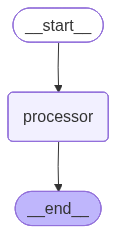

In [4]:
# ═══════════════════════════════════════════════════════════════
# GRAPH-EBENE: Technische Implementierung
# ═══════════════════════════════════════════════════════════════

# GRAPH: Erstelle die Datenstruktur
builder = StateGraph(WorkflowState)

# GRAPH: Füge Knoten hinzu (Map: "processor" → process_message)
builder.add_node("processor", process_message)

# GRAPH: Definiere die Struktur/Topologie
builder.add_edge(START, "processor")
builder.add_edge("processor", END)

# GRAPH: Kompiliere zu ausführbarem Objekt
graph = builder.compile(checkpointer=InMemorySaver(), debug=False)

# GRAPH: Visualisierung der Struktur
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
# ═══════════════════════════════════════════════════════════════
# AUSFÜHRUNG: Graph führt den Workflow aus
# ═══════════════════════════════════════════════════════════════

# GRAPH-API: Starte die Ausführung
response = graph.invoke(
    {"messages": [f"User: Starte den Prozess."]},
    {"configurable": {"thread_id": "simple_flow_1"}}
)

print("Alle Nachrichten:", response["messages"])

Alle Nachrichten: ['User: Starte den Prozess.', 'Bot: Nachricht erhalten und verarbeitet: User: Starte den Prozess.']


**Nodes - Kategorisierung nach Rolle**


| Kategorie (funktional) | Beschreibung | Beispiel |
|------------------------|--------------|----------|
| **Start-Node** | Einstiegspunkt in den Graphen; keine eigene Logik, definiert den Beginn des Ablaufs. | `START` |
| **End-Node** | Markiert das Ende der Ausführung; erhält typischerweise keine weiteren Übergänge. | `END` |
| **LLM-Node** | Enthält LLM- oder Entscheidungslogik, die den Zustand auswertet und neue Nachrichten oder Aktionen generiert. | `assistant`, `planner` |
| **Tool-Node** | Ruft externe Funktionen, APIs oder Datenquellen auf und erweitert den Zustand um Ergebnisse. | `search`, `database_query` |
| **Evaluator-Node** | Bewertet oder filtert Zwischenergebnisse, steuert ggf. den weiteren Ablauf. | `check_quality`, `approve_or_retry` |
| **Router-Node** | Leitet basierend auf Bedingungen an verschiedene Pfade weiter (`add_conditional_edges`). | `route_by_intent` |
| **Custom-Node** | Benutzerdefinierte Verarbeitungslogik ohne vordefinierte Rolle. | `normalize_text`, `extract_metadata` |


**Namenskonventionstabelle - Vorschlag**

| Ebene / Phase | Empfohlene Variable | Beschreibung | Beispiel |
|----------------|--------------------|---------------|-----------|
| **Graph-Definition** | `workflow` oder `graph_def` | Enthält die reine logische Definition des Graphen – also Nodes, Edges und Zustandsschema. | `workflow = StateGraph(state_schema=MessagesState)` |
| **Kompilierte Instanz** | `compiled_workflow` oder `graph` | Das lauffähige Objekt nach dem Kompilieren; enthält den initialisierten Zustand und Checkpointer. | `graph = workflow.compile(checkpointer=memory)` |
| **Zustand** | `state` | Repräsentiert den aktuellen Datenzustand während der Ausführung (z. B. Nachrichten, Kontext, Variablen). | `state = {"messages": [...]} ` |
| **Lauf / Ergebnis** | `result` oder `final_state` | Rückgabe nach der Ausführung oder nach Erreichen von `END`. | `result = graph.invoke(state)` |
| **Speicher / Persistenz** | `checkpointer` oder `memory` | Objekt zur Verwaltung von Zwischenzuständen und Verlauf. | `memory = MemorySaver()` |
| **Teilgraph / Subworkflow** | `subgraph` | Optionaler Untergraph für modularisierte Logik. | `subgraph = StateGraph(state_schema=TaskState)` |
| **LLM-Knoten** | `llm_node` oder `chat_fn` | Node-Funktion mit LLM- oder Entscheidungslogik. | `graph.add_node("chat", llm_node)` |
| **Toolknoten** | `tool_node` oder `tool_fn` | Node-Funktion, die externe Tools oder APIs aufruft. | `graph.add_node("search", tool_fn)` |


<p><font color='black' size="5">
State
</font></p>



Der **State** ist ein Herzstück von LangGraph. Es ist wie ...:

- Ein **Notizbuch**, das durch alle Schritte mitgetragen wird
- Eine **Pinnwand**, wo jeder Knoten Informationen abliest und hinzufügt
- Der **Arbeitsspeicher** des Workflows



Jeder Knoten kann:
- ✅ Daten aus dem State **lesen**
- ✅ Daten im State **ändern/ergänzen**
- ✅ Den State an den nächsten Knoten **weitergeben**

**✏️ Übung: Eigener einfacher Graph**

Erstellen Sie einen Graphen mit zwei Knoten:
1. **greet_user**: Begrüßt den User
2. **count_words**: Zählt die Wörter in der Begrüßung

<details>
<summary>💡 Lösung anzeigen</summary>

```python
class MyState(TypedDict):
    messages: List[str]
    word_count: int

def greet_user(state):
    greeting = "Hallo! Willkommen bei LangGraph!"
    return {"messages": [greeting], "word_count": 0}

def count_words(state):
    message = state['messages'][0]
    count = len(message.split())
    return {"word_count": count}

builder = StateGraph(MyState)
builder.add_node("greet", greet_user)
builder.add_node("count", count_words)
builder.add_edge(START, "greet")
builder.add_edge("greet", "count")
builder.add_edge("count", END)

graph = builder.compile()
result = graph.invoke({"messages": [], "word_count": 0})
print(f"Wörter gezählt: {result['word_count']}")  # Output: 5
```
</details>

# 4 | Memory und Checkpoint
---



LangGraph speichert den gesamten Graphen-Zustand über das **Checkpointer-System**. Eine `thread_id` dient als Schlüssel für die Persistenz.

**Checkpointing-Konzept**

Dieses Beispiel demonstriert, dass eine Information (`note`) im ersten Lauf im State gespeichert wird und im zweiten Lauf unter derselben `thread_id` verfügbar ist.

In [6]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, List
from IPython.display import Image

In [7]:
# ═══════════════════════════════════════════════════════════════
# WORKFLOW-EBENE: Fachliche Definition
# ═══════════════════════════════════════════════════════════════
# State für das Memory-Beispiel
class SimpleState(TypedDict):
    messages: List[str]
    note: str

# Knoten-Funktion
def store_note(state):
    message = state['messages'][-1]
    note = "Note from Run 1: {}".format(message)
    response = "Bot: Note stored."
    return {"messages": state["messages"] + [response], "note": note}

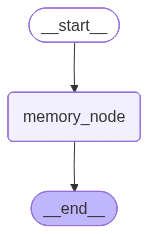

In [8]:
# ═══════════════════════════════════════════════════════════════
# GRAPH-EBENE: Technische Implementierung
# ═══════════════════════════════════════════════════════════════
# Graph-Aufbau
builder = StateGraph(SimpleState)
builder.add_node("memory_node", store_note)
builder.add_edge(START, "memory_node")
builder.add_edge("memory_node", END)

# Kompilierung mit debug=False (Standard)
# Für Debug-Output: debug=True setzen
graph = builder.compile(checkpointer=InMemorySaver(), debug=False)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# ═══════════════════════════════════════════════════════════════
# AUSFÜHRUNG: Graph führt den Workflow aus
# ═══════════════════════════════════════════════════════════════
# Invokierung (Run 1)
thread_id = "user_memory_session"
run_1 = graph.invoke(
    {"messages": ["User: Remember I like dogs."], "note": ""},
    {"configurable": {"thread_id": thread_id}}
)
print("Run 1 - State Note: {}".format(run_1['note']))


# Invokierung (Run 2: Lädt den gespeicherten State von Run 1)
run_2 = graph.invoke(
    {"messages": ["User: Load state."]},
    {"configurable": {"thread_id": thread_id}}
)
print("\nRun 2 - Geladene Note: {}".format(run_2['note']))

# Hinweis: Das Beispiel nutzt InMemorySaver. Für persistente Speicherung über Prozesse
# hinweg (z. B. nach einem Programmneustart) wäre ein PostgresSaver oder SQLAlchemySaver erforderlich.

Run 1 - State Note: Note from Run 1: User: Remember I like dogs.

Run 2 - Geladene Note: Note from Run 1: User: Load state.


# 5 | Bedingte Steuerung
---




Die **bedingte Kante** (`add_conditional_edges`) ist das Kernelement für die dynamische Steuerung, da sie den Workflow-Pfad basierend auf dem Ergebnis eines Knotens verzweigt.

**Beispiel: Bedingte Tool-Nutzung**

Dieses Beispiel zeigt einen **Router-Knoten**, der den Workflow zur Berechnung oder zur direkten Antwort steuert.

**Schema:** `START` → `router` → ( `math_tool` oder `final_answer` ) → `END`

**Was ist ein Router?**

Ein **Router** ist ein Knoten, der eine **Entscheidung trifft**:
"Wohin soll der Workflow als Nächstes gehen?"

**Analogie:** Wie eine Weiche bei der Bahn:
- Zug kommt an
- Weiche prüft: "ICE oder Regionalbahn?"
- Leitet den Zug auf das richtige Gleis

**Im Code:**
```python
def router_node(state):
    if "berechnen" in state['messages'][-1]:
        return {"next": "math_tool"}  # → Nimm den Werkzeug-Pfad
    return {"next": "final_answer"}   # → Nimm den Antwort-Pfad
```

In [10]:
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, List
from IPython.display import Image

In [11]:
# ═══════════════════════════════════════════════════════════════
# WORKFLOW-EBENE: Fachliche Definition
# ═══════════════════════════════════════════════════════════════
# Definiere den State
class ToolState(TypedDict):
    messages: List[str]
    next: str

# Knoten: Router (Routing-Funktion)
def router_node(state):
    last_message = state['messages'][-1].lower()
    if "calculate" in last_message or "summe" in last_message:
        return {"next": "math_tool"} # Return a dictionary with the next node
    return {"next": "final_answer"} # Return a dictionary with the next node

# Knoten: Tool (simuliert eine Berechnung)
def math_tool_node(state):
    response = "Bot: The result of your calculation is 42."
    return {"messages": state["messages"] + [response]}

# Knoten: Direkte Antwort
def direct_response_node(state):
    response = "Bot: I can only process math requests right now."
    return {"messages": state["messages"] + [response]}

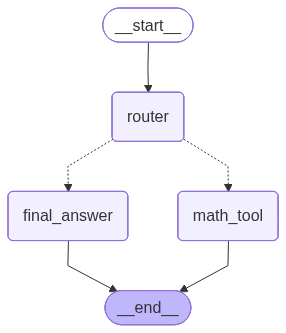

In [12]:
# ═══════════════════════════════════════════════════════════════
# GRAPH-EBENE: Technische Implementierung
# ═══════════════════════════════════════════════════════════════
# Graph-Konstruktion
builder = StateGraph(ToolState)
builder.add_node("router", router_node)
builder.add_node("math_tool", math_tool_node)
builder.add_node("final_answer", direct_response_node)

builder.add_edge(START, "router")

# Bedingte Kante
builder.add_conditional_edges(
    "router",
    lambda x: x["next"],
    {"math_tool": "math_tool", "final_answer": "final_answer"}
)

# Kanten zum Ende
builder.add_edge("math_tool", END)
builder.add_edge("final_answer", END)

# Kompilierung mit debug=False (für detaillierten Output: debug=True)
graph = builder.compile(debug=False)
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
# ═══════════════════════════════════════════════════════════════
# AUSFÜHRUNG: Graph führt den Workflow aus
# ═══════════════════════════════════════════════════════════════
# Test 1: Tool benötigt
response_tool = graph.invoke({"messages": ["User: Please calculate the sum."]})
print("1. Tool-Pfad: {}".format(response_tool['messages'][-1]))

# Test 2: Direkte Antwort benötigt
response_direct = graph.invoke({"messages": ["User: How are you?"]})
print("\n2. Antwort-Pfad: {}".format(response_direct['messages'][-1]))

1. Tool-Pfad: Bot: The result of your calculation is 42.

2. Antwort-Pfad: Bot: I can only process math requests right now.


# 6 | Anwendungsfälle und Integration
---

<p><font color='black' size="5">
Wann LangGraph sinnvoll ist?
</font></p>


LangGraph eignet sich, wenn ein System eine komplexe, **nicht-lineare Steuerung** benötigt.

- **Langlebige Chatbots:** Verwaltung des Gesprächszustands über Stunden/Tage hinweg (dank Checkpointing).
    
- **Multi-Bot-Systeme:** Koordination von Rollen (z. B. Research Bot → Review Bot → Final Answer Bot).
    
- **Workflow-Systeme mit Entscheidungslogik:** Komplexe Support-Automation, bei der Entscheidungen (Tool-Aufruf, Delegation, menschliches Eingreifen) auf Grundlage des State getroffen werden.


<p><font color='black' size="5">
Brücke zu LangChain: `ToolNode`
</font></p>

LangGraph kann nahtlos **LangChain Tools** nutzen. Der `ToolNode` ist ein spezieller LangGraph-Knoten, der automatisch das Input-/Output-Handling eines LangChain-Tools übernimmt.

In [14]:
from langchain.tools import tool
from langgraph.prebuilt import ToolNode

# Definiere ein LangChain Tool
@tool
def dummy_data_lookup(query):
    """Führt eine Datenabfrage durch und gibt ein Ergebnis zurück."""
    return f"Result for query '{query}': Data found."

# Das ToolNode wird als Knoten in den LangGraph eingefügt:
tool_node = ToolNode([dummy_data_lookup])

# In der Graph-Konstruktion würde nun 'tool_node' verwendet:
# builder.add_node("data_lookup_tool", tool_node)

# 7 | Fazit
---


LangGraph bietet eine Grundlage für die Entwicklung **adaptiver** und **zustandsorientierter** KI-Systeme. Durch die klare Trennung von **State**, **Knoten (Logik)** und **Kanten (Steuerung)** können Entwickler zuverlässige Workflows erstellen, deren Fokus auf dynamischen und fehlertoleranten Prozessen liegt.

# A | Glossar
---

| Begriff | Bedeutung |
|---------|-----------|
| **State** | Datencontainer, der durch alle Knoten fließt |
| **Node** | Ein Schritt/Aufgabe im Workflow (= Python-Funktion) |
| **Edge** | Verbindung zwischen Knoten (definiert den Ablauf) |
| **Workflow** | Der fachliche Ablauf: "Was soll in welcher Reihenfolge passieren?" |
| **Graph** | Die technische Umsetzung des Workflows aus Nodes + Edges |
| **START** | Spezieller Knoten: Einstiegspunkt |
| **END** | Spezieller Knoten: Endpunkt |
| **Conditional Edge** | Verzweigung: "Gehe zu Knoten A ODER B" |
| **Checkpointer** | Speichert den State, damit nichts verloren geht |
| **Router** | Knoten, der entscheidet, welcher Pfad genommen wird |
| **Builder** | Objekt zum Aufbauen des Graphen (StateGraph) |

# B | Debug-Optionen
---

LangGraph bietet mehrere Möglichkeiten, den Workflow-Prozess zu debuggen:

## 1. Debug beim Kompilieren

```python
# Debug-Modus für den gesamten Graphen aktivieren
graph = builder.compile(
    checkpointer=InMemorySaver(),
    debug=True  # 👈 Zeigt Details bei jedem invoke/stream
)
```

## 2. Debug beim Aufrufen

```python
# Debug nur für diesen spezifischen Aufruf
result = graph.invoke(
    {"messages": ["Test"]},
    debug=True  # 👈 Einmaliger Debug-Output
)
```

## 3. Debug-Streaming (Maximum Verbose)

```python
# Stream mit maximal detailliertem Output
for output in graph.stream(input, stream_mode="debug"):
    print(output)
```

**Zeigt:**
- 🔍 Inputs/Outputs für jeden Node
- 🛠️ Tool-Aufrufe mit Parametern
- 📊 Metadata (Run IDs, Timestamps)
- 💾 State-Updates zwischen Nodes

## 4. Alternative Stream-Modi

```python
# Nur finale States nach jedem Node
for output in graph.stream(input, stream_mode="values"):
    print(output)

# Nur State-Updates (Deltas)
for output in graph.stream(input, stream_mode="updates"):
    print(output)
```

**Empfehlung:** Für Lernen/Entwicklung → `debug=True` oder `stream_mode="debug"`  
Für Production → `debug=False` (Standard)